# Estimating the threshold of the color code with depolarizing noise

## Setup

In [1]:
import numpy as np
from typing import List, Dict
import functools
import itertools
import dataclasses

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import cirq
from mitiq import PauliString
import stim
import stimcirq

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

## Set experiment parameters

In [2]:
distance = 3
nshots = 10_000 # number of repetitions to run circuit
depths = np.arange(0, 100, 10) # number of X (NOT) gates to perform

simulator = stimcirq.StimSampler()

noise_rate = 0.001
noise = cirq.depolarize

PAULI_O = "Z"

## Helper functions

In [3]:
def int_to_bin_list(x, length):
    result = [0] * length
    for i in range(length):
        if x & (1 << i):
            result[length - 1 - i] = 1
    return result

def int_to_bin_str(x, length):
    return functools.reduce(lambda a, b: a + b, [str(b) for b in int_to_bin_list(x, length)])

def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key)))
        expectation += (-1) ** sum([key[i] for i in indices]) * value
    return expectation / sum(counts.values())

def noisy_identity(qreg, depth, noise) -> cirq.Circuit:
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))

    return circuit.with_noise(noise)

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

### Logical state preparation / encoding

In [4]:
@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

## Run physical experiment

In [5]:
# Noisy results
unmit_evs = []
for depth in depths:
    noisy_circuit = noisy_identity(cirq.LineQubit.range(1), depth, noise(p=noise_rate))
    if PAULI_O == "X":
        noisy_circuit.append(cirq.H.on(cirq.LineQubit(0)))
    elif PAULI_O == "Y":
        noisy_circuit.append(cirq.S.on(cirq.LineQubit(0))**-1)
        noisy_circuit.append(cirq.H.on(cirq.LineQubit(0)))
    noisy_circuit.append(cirq.measure(cirq.LineQubit(0), key="m"))
    counts = simulator.run(noisy_circuit, repetitions=nshots).histogram(key="m")
    counts = {int_to_bin_str(key, 1) : val for key, val in counts.items()}
    ev = compute_expectation(PauliString("X")._pauli, counts)
    print(np.real_if_close(ev))
    unmit_evs.append(np.real_if_close(ev))

0.9978
0.9866
0.9718
0.961
0.951
0.9298
0.9242
0.9152
0.9054
0.8884


## Run encoded experiment

In [6]:
generator_strs = get_stabilizer_generators(distance)
n = len(generator_strs[0])

print(generator_strs)
observable = PauliString(PAULI_O*n)._pauli

['IIXXIXX', 'XXXXIII', 'IXXIXXI', 'IIZZIZZ', 'ZZZZIII', 'IZZIZZI']


In [7]:
qreg = cirq.LineQubit.range(n)
stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))
print(encoding_circuit)

                   ┌──┐       ┌──┐       ┌──┐
0: ───RX───@───@────@───────────────────────────────────────────────────
           │   │    │
1: ───RX───┼───┼────┼@────@────@────────────────────────X───────────────
           │   │    ││    │    │
2: ───RX───┼───┼────┼┼────┼────┼@────@────@─────────────X───S───H───S───
           │   │    ││    │    ││    │    │
3: ───RX───@───┼────┼@────┼────┼@────┼────┼@────@───────────S───H───────
               │    │     │    │     │    ││    │
4: ───RX───────@────┼─────@────┼─────┼────┼┼────┼───────Z───────H───────
                    │          │     │    ││    │
5: ───RX────────────@──────────┼─────@────┼@────┼───@───Z───S───H───────
                               │          │     │   │
6: ───RX───────────────────────@──────────@─────@───@───────S───H───────
                   └──┘       └──┘       └──┘


In [8]:
transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
print(transformed_observable)

Z(q(3))*Z(q(6))


In [9]:
njobs: int = 16  # For parallelization.

expectation_values = []
for depth in depths:
    print("depth =", depth)

    circuit = (
        encoding_circuit.with_noise(noise(p=noise_rate)) + \
        noisy_identity(qreg, depth, noise(p=noise_rate)) + \
        measurement_circuit
    )
    # steine_circuit.with_noise(noise=cirq.depolarize(p=0))
    circuit.append(cirq.measure(qreg, key="result"))

    counts = simulator.run(circuit, repetitions=nshots).histogram(key="result")
    counts = {int_to_bin_str(key, n) : val for key, val in counts.items()}
    print(counts)

    def process(p):
        return p.coefficient * compute_expectation(p, counts)

    evals = Parallel(n_jobs=njobs)(delayed(process)(p) for p in observable_elements)
    numerator = np.average(evals).real

    print("Finished numerator")
    evals = Parallel(n_jobs=njobs)(delayed(process)(p) for p in stabilizer_elements)
    denominator = np.average(evals).real

    print("----------")
    print(numerator, denominator)
    print(numerator / denominator)
    print("----------")
    expectation_values.append(numerator / denominator)

print(expectation_values)

depth = 0
{'0000000': 9081, '1000000': 27, '1101101': 1, '0001110': 34, '0110000': 48, '0110101': 30, '0010000': 40, '1001000': 17, '1110000': 19, '1111110': 50, '0000111': 45, '0001000': 58, '1101100': 14, '1100000': 21, '1001110': 5, '0100111': 38, '0000001': 52, '0100000': 71, '1100100': 3, '1110010': 3, '0001010': 63, '1010000': 20, '0001100': 65, '0000101': 24, '1010010': 9, '0111100': 5, '1001100': 1, '1011010': 19, '0111010': 2, '0010001': 28, '0110100': 1, '0001101': 9, '0101101': 5, '0001001': 2, '0101010': 7, '0111101': 4, '0101100': 9, '0111000': 6, '1111000': 2, '1011110': 5, '0011110': 1, '0100001': 6, '1011001': 1, '1010110': 1, '0011100': 7, '1100001': 2, '0000100': 1, '1100010': 3, '1000010': 3, '1001001': 1, '1001010': 3, '1011000': 5, '1010100': 1, '1000110': 2, '1101110': 6, '0001011': 1, '1001011': 1, '0100100': 1, '0011000': 2, '1010111': 1, '0000010': 1, '0000110': 2, '1101000': 3, '0111111': 1, '1111100': 1}
Finished numerator
----------
0.9081 0.9081
1.0
-------

## Plot

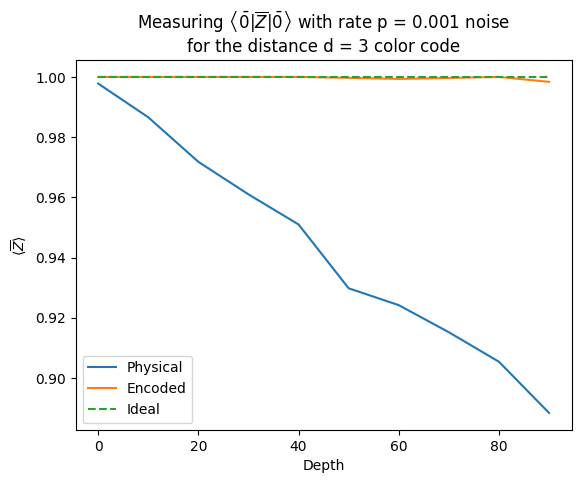

In [10]:
plt.plot(depths, unmit_evs, label="Physical")
plt.plot(depths, expectation_values, label="Encoded")
plt.plot(depths, [1.0 if PAULI_O == "Z" else 0.0]*len(depths), "--", label="Ideal")
plt.legend()
plt.xlabel("Depth")
plt.ylabel("$\\left<\\overline{Z}\\right>$")
plt.title("Measuring $\\left< \\bar{0} | \\overline{Z} | \\bar{0} \\right>$" + f" with rate p = {noise_rate} noise \nfor the distance d = {distance} color code");